In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
from astropy.io import fits
from astropy import wcs
import pandas as pd
import sys
from tqdm import tqdm
from astropy.visualization import ZScaleInterval
from glob import glob
import csv
#import seaborn as sns

from multiprocessing import Pool
import time as tm

from uncertainties import ufloat
from scipy import constants as con
from astropy import constants as ascon
from astropy import units as u
#import pyregion

In [2]:
from mrexo import predict_from_measurement, generate_lookup_table

# TSM

https://arxiv.org/pdf/1805.03671.pdf

In [3]:
def TSM(rp, mp, teq, rs, m_J) :
    
    if rp < 1.5:
        scale = 0.190
    elif rp < 2.75:
        scale = 1.26
    elif rp < 4.0:
        scale = 1.28
    else: 
        scale = 1.15
        
    return scale*rp**3 * teq / (mp * rs **2) * 10**(-m_J/5.)

## TOI 1696.01	/ TIC 470381900.01

In [4]:
Rp_tg = 3.04 #Rearth 
Rp_err_tg = 0.1

Teq_tg  = 477 #pm 24, K
Per_tg = 2.5

Teff_tg  = 3156
Rs_tg  = 0.276

mJ_tg  =12.233
mK_tg  = 11.331

dep_tg=((Rp_tg*6.3781e8)/(Rs_tg*6.957e10))**2

In [5]:
Mp_tg, Mp_qtls_tg, iron_planet = predict_from_measurement(measurement=Rp_tg , measurement_sigma=Rp_err_tg, dataset='mdwarf',  is_posterior=False, show_plot=False)
#print(Mp_tg, Mp_qtls_tg)

In [43]:
Mp_tg

7.904125328527755

In [6]:
TSM_tg=TSM(Rp_tg , Mp_tg , Teq_tg , Rs_tg , mJ_tg )
TSM_tg

101.87722750717255

## Importing data from NASA Exoplanet Archive

In [7]:
all_planets = pd.read_csv('/home/mori/toi1696/data/PS_2022.01.28_05.09.39.csv', skiprows=290)
all_planets

,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_id,default_flag,sy_snum,sy_pnum,...,sy_kepmagerr2,rowupdate,pl_pubdate,releasedate,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec
0,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,1,2,1,...,NaN,2014-05-14,2008-01,2014-05-14,2,1,2,0,0,0
1,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,0,2,1,...,NaN,2014-07-23,2011-08,2014-07-23,2,1,2,0,0,0
2,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,0,1,1,...,NaN,2018-04-25,2011-08,2014-07-23,0,1,1,0,0,0
3,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,1,1,1,...,NaN,2018-09-04,2017-03,2018-09-06,0,1,1,0,0,0
4,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,0,1,1,...,NaN,2018-04-25,2009-10,2014-05-14,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32052,ups And d,ups And,d,HD 9826,HIP 7513,TIC 189576919,Gaia DR2 348020448377061376,0,2,3,...,NaN,2021-09-20,2021-05,2021-09-20,0,1,10,1,0,0
32053,ups And d,ups And,d,HD 9826,HIP 7513,TIC 189576919,Gaia DR2 348020448377061376,0,2,3,...,NaN,2021-08-03,2010-06,2021-08-03,0,1,10,1,0,0
32054,ups Leo b,ups Leo,b,NaN,NaN,TIC 49430557,Gaia DR2 3794167001116433152,1,1,1,...,NaN,2022-01-10,2021-12,2022-01-10,0,0,0,0,0,0
32055,xi Aql b,xi Aql,b,HD 188310,HIP 97938,TIC 375464367,Gaia DR2 4298361114750843904,0,1,1,...,NaN,2014-07-23,2011-08,2014-07-23,1,1,1,0,0,0


In [8]:
all_planets=all_planets[all_planets['default_flag']==1]
len(all_planets)

4908

In [9]:
planets=all_planets[all_planets['st_teff']<4000]
len(planets)

358

In [10]:
planets=all_planets[all_planets['st_teff']<4000]

#TSM
planets=planets[planets['pl_rade'].notna()]
planets=planets[planets['pl_rade']<10]

planets=planets[planets['pl_orbsmax'].notna()]  
planets=planets[planets['st_rad'].notna()]

planets=planets[planets['sy_jmag'].notna()]
planets=planets.reset_index()
len(planets)

161

### mass calculation

In [11]:
#this will take several minutes
mass_list = []

for r, re in zip(planets['pl_rade'], planets['pl_radeerr1']):
    mass, _, _ = predict_from_measurement(measurement=r , measurement_sigma=re, dataset='mdwarf',  is_posterior=False, show_plot=False)
    mass_list.append(mass)

Mass of 100% Iron planet of 1.047 Earth Radii = 2.9532555947705807 Earth Mass (Fortney, Marley and Barnes 2007)
Mass of 100% Iron planet of 1.13 Earth Radii = 4.063133338971838 Earth Mass (Fortney, Marley and Barnes 2007)
Mass of 100% Iron planet of 1.193 Earth Radii = 5.129589837922454 Earth Mass (Fortney, Marley and Barnes 2007)
Mass of 100% Iron planet of 1.264 Earth Radii = 6.614501710423345 Earth Mass (Fortney, Marley and Barnes 2007)
Mass of 100% Iron planet of 1.217 Earth Radii = 5.595278563380514 Earth Mass (Fortney, Marley and Barnes 2007)
Mass of 100% Iron planet of 0.718 Earth Radii = 0.6963610159547223 Earth Mass (Fortney, Marley and Barnes 2007)
Mass of 100% Iron planet of 1.04 Earth Radii = 2.87290802874415 Earth Mass (Fortney, Marley and Barnes 2007)
Mass of 100% Iron planet of 0.89 Earth Radii = 1.5451807019906942 Earth Mass (Fortney, Marley and Barnes 2007)
Mass of 100% Iron planet of 1.1 Earth Radii = 3.626567898484023 Earth Mass (Fortney, Marley and Barnes 2007)
Mass

In [12]:
planets['mass_calc'] = mass_list

(0.0, 30.0)

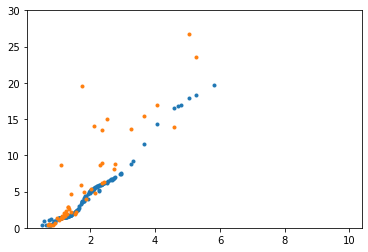

In [13]:
pl.plot(planets['pl_rade'],planets['mass_calc'], '.')
pl.plot(planets['pl_rade'],planets['pl_masse'], '.')
pl.ylim(0, 30)

In [14]:
import math

In [15]:
planets['mass_combine'] = planets['pl_masse']

for i in range(len(planets)):
    if math.isnan(planets['pl_masse'][i])==True:
        planets['mass_combine'][i] =planets['mass_calc'][i]

(0.0, 30.0)

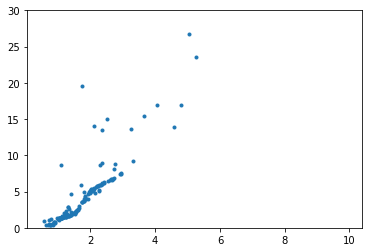

In [16]:
pl.plot(planets['pl_rade'],planets['mass_combine'], '.')
pl.ylim(0, 30)

### Teq Calculation

In [17]:
def Teq(Teff, R_s, semi): #[L_sol]
    R_s_m = R_s * ascon.R_sun
    semi_m = semi * ascon.au
    return Teff * (R_s_m/2./semi_m)**0.5

teff_s = planets['st_teff']
rs_s = planets['st_rad']
a_s = planets['pl_orbsmax']

planets['teq_calc'] = Teq(teff_s, rs_s, a_s)

In [18]:
len(planets)

161

In [19]:
len(planets[planets['pl_eqt'].notna()])

97

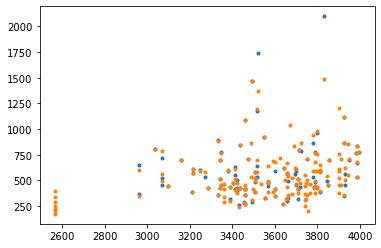

In [20]:
pl.plot(planets['st_teff'], planets['pl_eqt'],'.')
pl.plot(planets['st_teff'], planets['teq_calc'],'.')
#pl.ylim(0,1000)

In [21]:
planets['teq_combine'] = planets['pl_eqt']

for i in range(len(planets)):
    if math.isnan(planets['pl_eqt'][i])==True:
        planets['teq_combine'][i] =planets['teq_calc'][i]

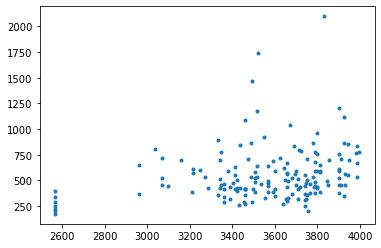

In [22]:
pl.plot(planets['st_teff'], planets['teq_combine'],'.')

# TSM Calculation

In [23]:
Rp = planets['pl_rade']

#Mp = planets['pl_masse']
Mp = planets['mass_combine']

#Teq = planets['pl_eqt']
Teq = planets['teq_combine']

Rs = planets['st_rad']
mJ = planets['sy_jmag']

tsm=[]
for n in range(len(Rp)):
    tsm.append(TSM(Rp[n], Mp[n], Teq[n], Rs[n], mJ[n]))

planets['TSM'] = tsm
planets_TSM = planets

In [24]:
planets_TSM.sort_values('TSM', ascending=False).loc[:,['pl_name','TSM', 'pl_eqt', 'pl_rade']].reset_index()

,index,pl_name,TSM,pl_eqt,pl_rade
0,5,GJ 1214 b,482.123733,596.0,2.742
1,0,AU Mic b,393.336558,593.0,4.070
2,113,L 98-59 d,273.657452,416.0,1.521
3,7,GJ 3470 b,270.204580,594.0,4.570
4,148,TOI-674 b,215.148782,635.0,5.250
...,...,...,...,...,...
156,95,Kepler-32 c,0.194939,NaN,2.000
157,134,TOI-1749 b,0.150314,831.0,1.390
158,94,Kepler-32 b,0.042452,NaN,2.200
159,23,K2-137 b,0.028423,1471.0,0.890


## making figure

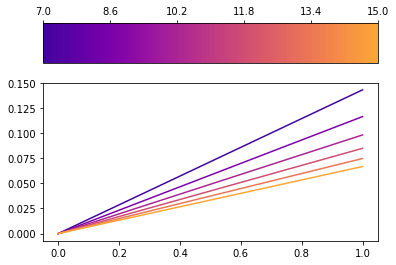

In [25]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.patches as patches
import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec 
import matplotlib.colors as mcolors 

gs = gridspec.GridSpec(2, 1, 
         height_ratios=[1, 4] 
         ) 
ax = [plt.subplot(g) for g in gs] 

parameterToColorBy = np.linspace(7, 15, 6, dtype=float) 

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1): 
    if n == -1: 
        n = cmap.N 
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
     'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval), 
     cmap(np.linspace(minval, maxval, n))) 
    return new_cmap 

minColor = 0.1
maxColor = 0.8
inferno_t = truncate_colormap(plt.get_cmap("plasma"), minColor, maxColor) 

colors = [inferno_t(i) 
      for i in np.linspace(0, 1, parameterToColorBy.shape[0])] 

norm = mpl.colors.Normalize(parameterToColorBy[0], 
          parameterToColorBy[-1]) 

cb = mpl.colorbar.ColorbarBase(ax[0], 
           cmap=inferno_t, 
           norm=norm, 
           ticks=parameterToColorBy, 
           orientation='horizontal') 

ax[0].xaxis.set_ticks_position('top') 

for p, c in zip(parameterToColorBy, colors): 
    ax[1].plot(np.arange(2)/p, c=c) 

In [26]:
df=planets_TSM

In [27]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
pl.rcParams['ytick.labelsize'] = 'medium'
pl.rcParams['xtick.labelsize'] ='medium'
fontsize=20

In [28]:
Rp_plot = list(df['pl_rade'])
Rp_plot.append(Rp_tg)

Per_plot = list(df['pl_orbper'])
Per_plot.append(Per_tg)

eq_plot = list(df['pl_eqt'])
eq_plot.append(Teq_tg)
#eq_plot

tsm_plot=list(df['TSM'])
tsm_plot.append(TSM_tg)

#hmag_plot = list(df['sy_hmag'])
#hmag_plot.append(11.604)

In [29]:
TSM_tg

101.87722750717255

In [30]:
f = pl.figure(figsize=(12,8))

#df = planets_TSM[planets_TSM['sy_hmag']<11]
df = planets_TSM

sc =pl.scatter(eq_plot,tsm_plot,  alpha=1, c=hmag_plot, cmap=inferno_t)

#sc =pl.scatter(df['pl_eqt'],df['TSM'],  alpha=1, c=df['sy_hmag'], cmap=inferno_t)
#sc =pl.scatter(df['pl_eqt'],df['TSM'],  s=df['pl_trandep']*100, alpha=1, c=df['sy_hmag'], cmap=inferno_t, label=': Depth=1%')
pl.colorbar(sc, label='H-band magnitude[mag]')
pl.legend(loc="upper right", markerscale=1., scatterpoints=1, fontsize=15)

plt.scatter(Teq_tg, TSM_tg,  facecolor='None', edgecolors='deepskyblue', s=180)

pl.xlabel('Planetary Equilibrium Temperature (K)',fontsize=18)
pl.ylabel(r'TSM', fontsize=18)

#pl.legend()
#pl.text(210,0.6, 'TRAPPIST-1 Planets',fontsize=18, c='orange')
#pl.xlim(200, 1200)
pl.ylim(-2, 48)
f.savefig('TSM_scatter.png')

NameError: name 'hmag_plot' is not defined

<Figure size 864x576 with 0 Axes>

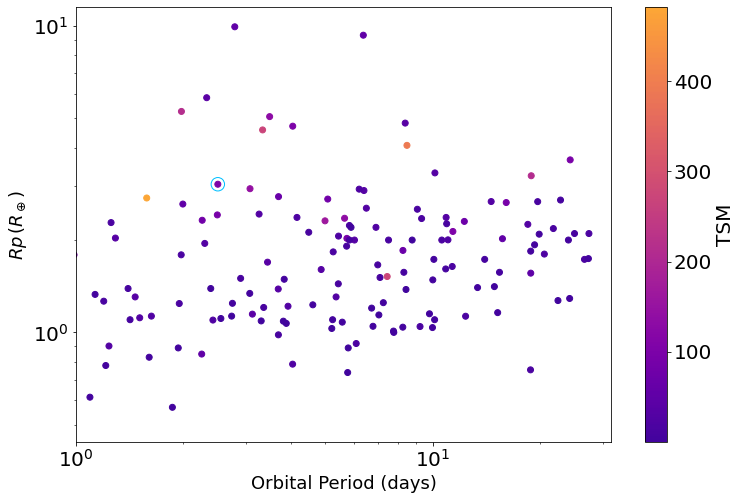

In [31]:
f = pl.figure(figsize=(12,8))

#df = planets_TSM[planets_TSM['sy_hmag']<11]
df = planets_TSM

sc =pl.scatter(Per_plot, Rp_plot,  alpha=1, c=tsm_plot, cmap=inferno_t)

pl.colorbar(sc, label='TSM')
#pl.legend(loc="upper right", markerscale=1., scatterpoints=1, fontsize=15)


plt.scatter(Per_tg, Rp_tg,  facecolor='None', edgecolors='deepskyblue', s=180)

pl.xlabel('Orbital Period (days)',fontsize=18)
pl.ylabel(r'$Rp\,(R_\oplus)$', fontsize=18)

pl.loglog()
pl.xlim(1,10**1.5)
#pl.ylim(1, 10**0.7)

f.savefig('TSM_scatter.png')

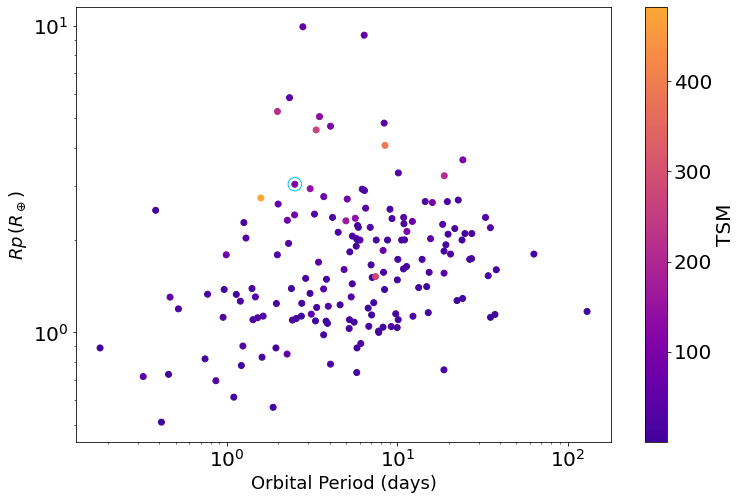

In [32]:
f = pl.figure(figsize=(12,8))

df = planets_TSM[planets_TSM['sy_hmag']<11]
#df = planets_TSM

sc =pl.scatter(Per_plot, Rp_plot,  alpha=1, c=tsm_plot, cmap=inferno_t)

pl.colorbar(sc, label='TSM')
#pl.legend(loc="upper right", markerscale=1., scatterpoints=1, fontsize=15)


plt.scatter(Per_tg, Rp_tg,  facecolor='None', edgecolors='deepskyblue', s=180)

pl.xlabel('Orbital Period (days)',fontsize=18)
pl.ylabel(r'$Rp\,(R_\oplus)$', fontsize=18)

pl.loglog()
#pl.xlim(1,10**1.5)
#pl.ylim(1, 10**0.7)

f.savefig('TSM_scatter.png')

In [33]:
planets_largeTSM = planets_TSM[planets_TSM['TSM']>TSM_tg].reset_index()
len(planets_largeTSM)

12

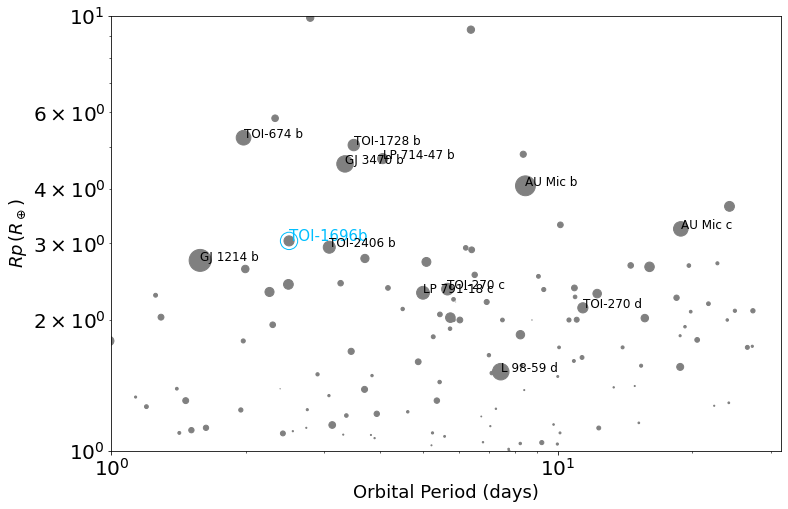

In [42]:
f = pl.figure(figsize=(12,8))

df = planets_TSM[planets_TSM['sy_hmag']<11]
#df = planets_TSM

sc =pl.scatter(Per_plot, Rp_plot,  alpha=1, s=tsm_plot, c='gray')

#pl.legend(loc="upper right", markerscale=1., scatterpoints=1, fontsize=15)


plt.scatter(Per_tg, Rp_tg,  facecolor='None', edgecolors='deepskyblue', s=300)

pl.text(Per_tg, Rp_tg, 'TOI-1696b', c='deepskyblue', fontsize=15)

for n in range(len(planets_largeTSM)):
    pl.text(planets_largeTSM['pl_orbper'][n],planets_largeTSM['pl_rade'][n],planets_largeTSM['pl_name'][n], fontsize=12)

pl.xlabel('Orbital Period (days)',fontsize=18)
pl.ylabel(r'$Rp\,(R_\oplus)$', fontsize=18)

pl.loglog()
pl.xlim(1,10**1.5)
pl.ylim(1, 10**1)

f.savefig('TSM_scatter.png')

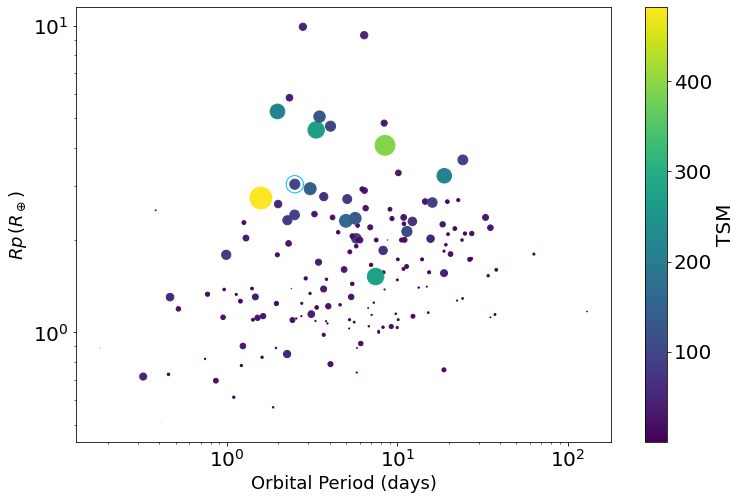

In [46]:
f = pl.figure(figsize=(12,8))

df = planets_TSM[planets_TSM['sy_hmag']<11]
#df = planets_TSM

sc =pl.scatter(Per_plot, Rp_plot,  alpha=1, c=tsm_plot, s=tsm_plot)

pl.colorbar(sc, label='TSM')
#pl.legend(loc="upper right", markerscale=1., scatterpoints=1, fontsize=15)


plt.scatter(Per_tg, Rp_tg,  facecolor='None', edgecolors='deepskyblue', s=300)

pl.xlabel('Orbital Period (days)',fontsize=18)
pl.ylabel(r'$Rp\,(R_\oplus)$', fontsize=18)

pl.loglog()
#pl.xlim(1,10**1.5)
#pl.ylim(1, 10**0.7)

f.savefig('TSM_scatter.png')

No handles with labels found to put in legend.


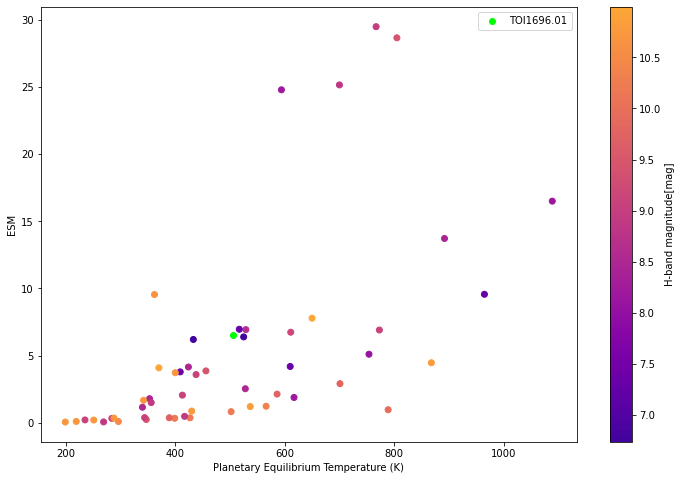

In [347]:
f = pl.figure(figsize=(12,8))

df = planets_ESM[planets_ESM['sy_hmag']<11]

#sc =pl.scatter(df['pl_eqt'],df['ESM'],  s=df['pl_trandep']*100, alpha=1, c=df['sy_hmag'], cmap=inferno_t, label=': Depth=1%')
sc =pl.scatter(df['pl_eqt'],df['ESM'],  alpha=1, c=df['sy_hmag'], cmap=inferno_t)
pl.colorbar(sc, label='H-band magnitude[mag]')
pl.legend(loc="upper right", markerscale=1., scatterpoints=1, fontsize=15)

#pl.scatter(Teq_tg, ESM_tg,  (dep_tg*100), facecolor='skyblue', edgecolors='red', lw=2,  label='TOI1696.01')
pl.scatter(Teq_tg, ESM_tg, facecolor='lime', label='TOI1696.01')

pl.xlabel('Planetary Equilibrium Temperature (K)')
pl.ylabel(r'ESM')

#pl.text(210,0.6, 'TRAPPIST-1 Planets',fontsize=18, c='orange')

#pl.xlim(820, 100)
pl.legend()

#f.savefig('S21A_scatter2.png')

samples: planets with Teff < 4000K & H < 11mag with all information needed